In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import preprocess

from PIL import Image
from multiprocessing import Pool
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
IMG_SIZE = 256

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return np.array(image)

In [3]:
image_dir = "data/train_images/"

train_df = pd.read_csv("data/train.csv")
train_df["path"] = image_dir + train_df["id_code"] + ".png"

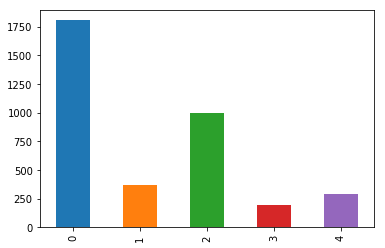

In [20]:
train_df["diagnosis"].value_counts().sort_index().plot.bar()

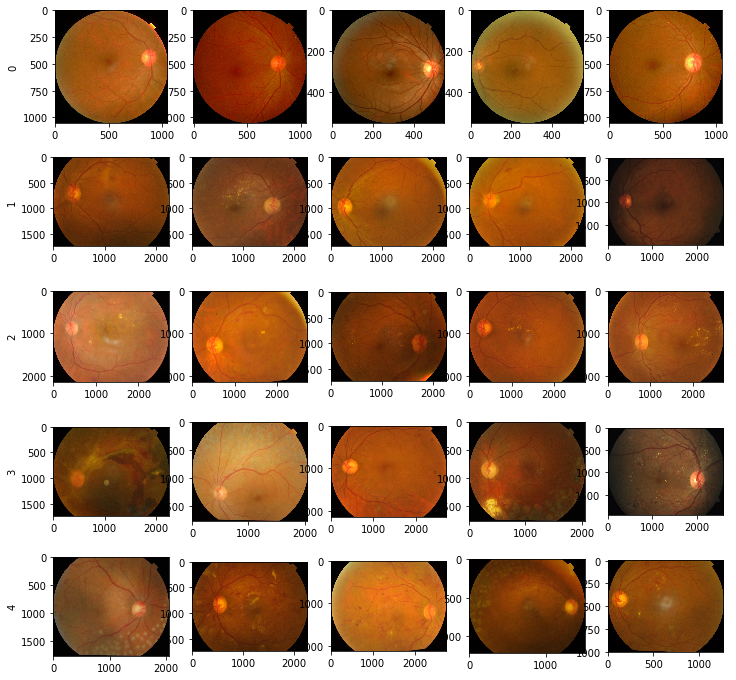

In [7]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for i in range(5):
    samples = train_df[train_df["diagnosis"] == i]["id_code"].sample(5)
    for j in range(5):
        img = np.array(Image.open(os.path.join(image_dir, samples.iloc[j] + ".png")))
        img = crop_image_from_gray(img)
        axes[i][j].imshow(img)
    axes[i][0].set_ylabel(i)

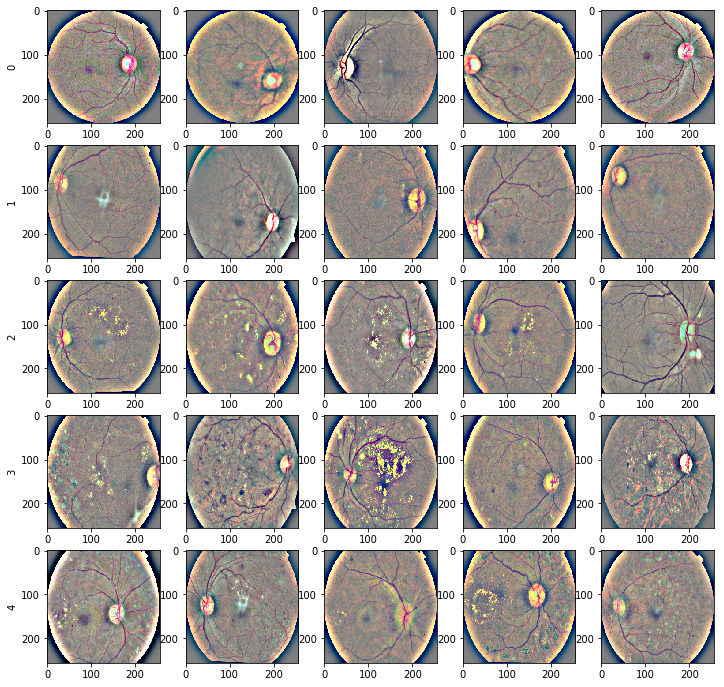

In [19]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for i in range(5):
    samples = train_df[train_df["diagnosis"] == i]["id_code"].sample(5)
    for j in range(5):
        img = np.array(Image.open(os.path.join(image_dir, samples.iloc[j] + ".png")))
        img = load_ben_color(img, (256, 256))
        img = crop_image_from_gray(img)
        axes[i][j].imshow(img)
    axes[i][0].set_ylabel(i)

In [3]:
def get_mean_value_by_channel(id_code):
    img = np.array(Image.open(os.path.join(image_dir, id_code + ".png")))
    return np.mean(img, axis=(0, 1)), np.std(img, axis=(0, 1))

In [11]:
# means = []
# stds = []

pool = Pool(10)
res = pool.map(get_mean_value_by_channel, train_df["id_code"])

# for i, id_code in enumerate(train_df["id_code"]):
#     mean, std = get_mean_value_by_channel(id_code)
#     means.append(mean)
#     stds.append(stds)


In [23]:
means = np.array([v[0] for v in res])
stds = np.array([v[1] for v in res])

print("Mean: {mean}, Std: {std}".format(mean=np.mean(means, axis=0), std=np.mean(stds, axis=0)))

Mean: [105.52776859  56.36061928  18.78834612], Std: [60.92763057 33.665175   12.66183186]


In [26]:
seed = 404

train, val = train_test_split(train_df, test_size=0.15, train_size=0.85, random_state=seed)

In [32]:
train.to_csv("data/training_set.csv", index=None)
val.to_csv("data/validation_set.csv", index=None)

In [40]:
generator = preprocess.ImageGenerator(train_df, batch_size=16, image_size=(299, 299), preprocess_fn=preprocess.mean_std_normalization)

In [41]:
batch_generator = generator.batch_generator()